In [1]:
from Minesweeper import *
from MS_GUI import *
from MS_AI import *
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

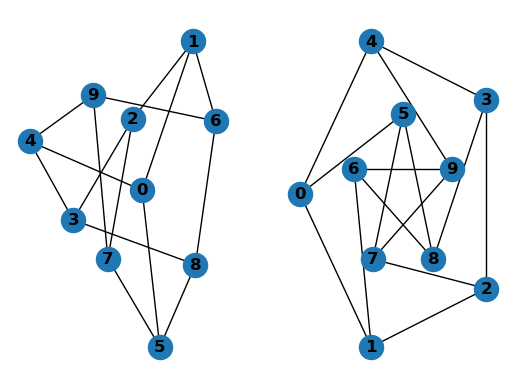

In [2]:
G = nx.petersen_graph()
subax1 = plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')
subax2 = plt.subplot(122)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

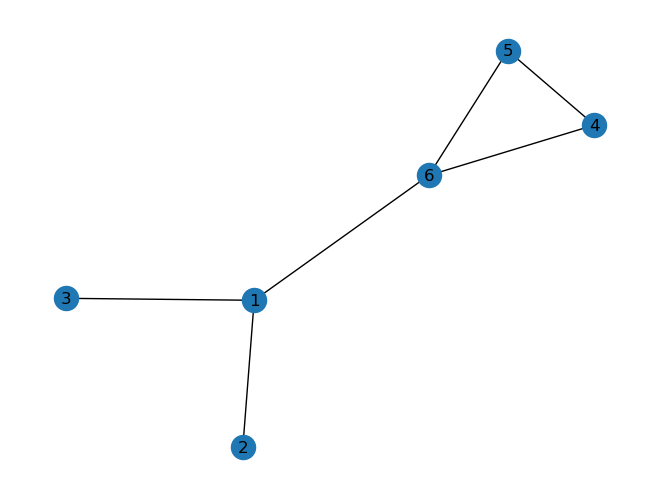

In [3]:
graph = nx.Graph()

graph.add_node(1, tile=MS_Tile(1))
graph.add_node(2, tile=MS_Tile(2))
graph.add_node(3, tile=MS_Tile(3))
graph.add_edge(1, 2)
graph.add_edge(1, 3)

graph.add_node(4, tile=MS_Tile(4))
graph.add_node(5, tile=MS_Tile(5))
graph.add_node(6, tile=MS_Tile(6))
graph.add_edge(4, 5)
graph.add_edge(4, 6)
graph.add_edge(6, 1)
graph.add_edge(5, 6)

nx.draw(graph, with_labels=True, pos=nx.spring_layout(graph))

In [14]:
for comp in nx.connected_components(graph):
    for v in comp:
        print(v)

1
2
3
4
5
6


In [4]:
reduce(lambda x,y: x.union(set(y)), [graph.neighbors(i) for i in graph], set())

{1, 2, 3, 4, 5, 6}

In [5]:
import z3
from functools import reduce
from itertools import combinations

In [6]:
a = z3.Bool('a')

In [7]:
def all_smt(s, initial_terms):
    def block_term(s, m, t):
        s.add(t != m.eval(t, model_completion=True))
    def fix_term(s, m, t):
        s.add(t == m.eval(t, model_completion=True))
    def all_smt_rec(terms):
        if z3.sat == s.check():
           m = s.model()
           yield m
           for i in range(len(terms)):
               s.push()
               block_term(s, m, terms[i])
               for j in range(i):
                   fix_term(s, m, terms[j])
               yield from all_smt_rec(terms[i:])
               s.pop()   
    yield from all_smt_rec(list(initial_terms))

def exactly_n(vars, n):
    ands = []
    for comb in combinations(vars, n):
        trues = reduce(z3.And, comb)
        falses = reduce(z3.And, [z3.Not(var) for var in vars if not var in comb])
        ands.append(z3.And(trues, falses))
    return reduce(z3.Or, ands)

In [8]:
vars = {i:z3.Bool(f"t{i}") for i in range(4)}
t1_cond = exactly_n(vars.values(), 1)
s = z3.Solver()
s.add(t1_cond)

In [9]:
print(t1_cond)
for m in all_smt(s, vars.values()):
    print(m)

Or(Or(Or(And(t0, And(And(Not(t1), Not(t2)), Not(t3))),
         And(t1, And(And(Not(t0), Not(t2)), Not(t3)))),
      And(t2, And(And(Not(t0), Not(t1)), Not(t3)))),
   And(t3, And(And(Not(t0), Not(t1)), Not(t2))))
[t0 = False, t2 = False, t1 = True, t3 = False]
[t0 = True, t2 = False, t1 = False, t3 = False]
[t0 = False, t2 = True, t1 = False, t3 = False]
[t0 = False, t2 = False, t1 = False, t3 = True]


In [10]:
foo = list(all_smt(s, vars.values()))

In [11]:
z3.is_true(foo[0][vars[2]])

True

In [12]:
foo[0]

[t0 = False, t2 = True, t1 = False, t3 = False]